In [1]:
from codes.python import load_database,ECG_denoising
from codes.python import QRS_detector
import numpy as np
from scipy.signal import resample
from scipy.signal import savgol_filter
import operator
from numpy import array
import sys
import csv
import os
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing, plot
from codes.python import heartbeat_segmentation as shs
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from codes.python import curve_smoothing 

In [2]:

def is_class_MIT(classAnttd):
    MITBIH_classes = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F']#, 'P', '/', 'f', 'u']
    if classAnttd in MITBIH_classes:
        return True
    else:
        return False
        

def check_class_AAMI(classAnttd, class_AAMI):
    AAMI_classes = []
    AAMI_classes.append(['N', 'L', 'R'])                    # N
    AAMI_classes.append(['A', 'a', 'J', 'S', 'e', 'j'])     # SVEB 
    AAMI_classes.append(['V', 'E'])                         # VEB
    AAMI_classes.append(['F'])
    for i in range(0,len(AAMI_classes)):

        if classAnttd in AAMI_classes[i]:
            class_AAMI = i      

    return class_AAMI

def segment(signal,pos,winL,winR,size_RR_max):
    lst = list(signal[pos - size_RR_max : pos + size_RR_max])
    
    
    if(signal[pos] < 0):
        beat_pos = [abs(x) for x in lst]
        beat_pos = enumerate(beat_pos)
        index, value  = max(beat_pos, key=operator.itemgetter(1))
        pos = (pos - size_RR_max) + index
    
    else:
        beat_pos = enumerate(lst)
        index, value  = max(beat_pos, key=operator.itemgetter(1))
        pos = (pos - size_RR_max) + index

    beat_poses = list(range(pos - winL, pos + winR))
    beat_poses = [int(i) for i in beat_poses]
    return beat_poses,pos

def r_peak_and_annotation(signal,annotations, indexes, winL=180, winR=180,size_RR_max=5):
    class_ID = []
    
    originalPoses = []
   
    R_poses = []
    beat_class = []
    class_AAMI = -1
    
    for a in annotations:
    
        aS = a.split()
        pos = int(aS[1])

       

        if(len(signal) < len(indexes)):
            break

        if(indexes[len(indexes)-1] < pos):
            break

        if(indexes[0] > pos):
            continue
        
        originalPos = int(aS[1])
        classAnttd = str(aS[2])

        if pos > size_RR_max and pos < (len(signal) - size_RR_max):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
        #time_beat = list(time[beat_poses[0] : beat_poses[len(beat_poses)-1]+1])
            pos = pos - indexes[0]
            if(pos > winL and pos < (len(indexes) - winR)):
                
                R_poses.append(pos)
                class_AAMI = check_class_AAMI(classAnttd, class_AAMI)
                class_ID.append(class_AAMI)
                beat_class.append(classAnttd)
                originalPos = originalPos-indexes[0]
                originalPoses.append(originalPos)

    return beat_class, class_ID, R_poses, originalPoses

def segment_beat(signal,r_poses, upper_left_limit=0, upper_right_limit=0, winL=180,  winR=180,size_RR_max=5):
    upper_left_limit = winL+upper_left_limit
    upper_right_limit = winR+upper_right_limit
    beats = []
    beat_pos = []
    for pos in r_poses:
        
        if pos > size_RR_max and pos < (len(signal) - size_RR_max ):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
            if(pos <= upper_left_limit):
                beat = signal[pos - winL : pos + upper_right_limit]
                beat_poses = list(range(pos - winL, pos + upper_right_limit))
                beat_poses = [int(i) for i in beat_poses]
                #print(beat, pos)
                
            if(pos >= (len(signal) - upper_right_limit)):
                beat = signal[pos - upper_left_limit : pos + winR]
                beat_poses = list(range(pos - upper_left_limit, pos + winR))
                beat_poses = [int(i) for i in beat_poses]
               # print("here", str(pos))
                #print(beat)

            if(pos > upper_left_limit and pos < (len(signal) - upper_right_limit)):
                
                beat = signal[pos - upper_left_limit : pos + upper_right_limit]
                beat_poses = list(range(pos - upper_left_limit, pos + upper_right_limit))
                beat_poses = [int(i) for i in beat_poses]
                
            if(pos > winL and pos < (len(signal) - winR)):
                beats.append(beat)
                beat_pos.append(beat_poses)
                
                #print(pos)
                
    return np.asarray(beats), np.asarray(beat_pos)

def r_peak(signal,r_peak, winL=180, winR=180,size_RR_max=5):
    
    R_poses = []
    class_AAMI = -1
    for r in r_peak:
        pos = r
        if(pos > len(signal)):
            break  
        
        if pos > size_RR_max and pos < (len(signal) - size_RR_max):
            beat_poses,pos=segment(signal,pos,winL,winR, size_RR_max)
            
            if(pos > winL and pos < (len(signal) - winR)):
               
                R_poses.append(pos)
                
    return R_poses


In [3]:
mit100 = load_database.load_patient_record("mitdb","100")
mit100.set_segmented_beats_r_pos(winL=100,winR=200)



C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/100
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.csv
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/csv/100.txt
C:\Users\nimch681\Documents\git_projects\ECGdataAnalysis/database/mitdb/p_t_wave/100pt.csv
Start segmenting records: 100
Filtered MLII records from : 100
start segmenting MLII.
Finished segmenting MLII.
Segmenting record 100 completes.


In [4]:
beats, beat_pos = segment_beat(mit100.filtered_MLII, mit100.segmented_R_pos,upper_left_limit=300, upper_right_limit=300)

In [5]:
beat_pos[0]

[191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357

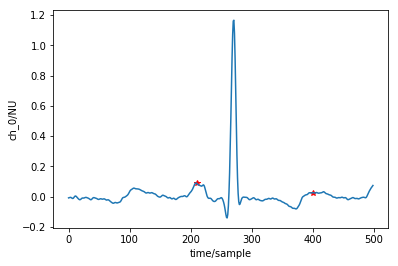

In [24]:
p_waves = mit100.annotated_p_waves_pos[0:1]

p_waves = [int(b) for b in p_waves]
p_waves = list([210, 400])
p_wave = np.asarray(p_waves)
wfdb.plot_items(signal=mit100.filtered_MLII[100:600], ann_samp=[p_wave])



[311.0, 605.0, 885.0, 1168.0, 1456.0, 1747.0, 1983.0, 2339.0, 2643.0, 2938.0]

In [ ]:
beat